In [1]:
import os
import json

import numpy as np
import pandas as pd
from scipy.sparse import hstack
import string
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
seed = 291

In [3]:
data_dir = "../data/runtime"
data = pd.read_csv(os.path.join(data_dir, "proccessed-data.csv"))
data.head()

,query,runtime (ms),query_complexity,runtime_boolean,table_size,length
0,select distinct coursealias0advisory_requireme...,8.092165,1,1,11453,15
1,select distinct coursealias0department coursea...,0.772238,1,0,11531,34
2,select distinct coursealias0department coursea...,0.530958,1,0,11531,36
3,select count 0 from course as coursealias0 cou...,92.988014,0,1,326457,53
4,select distinct coursealias0department coursea...,1.093864,1,0,23060,56


In [4]:
labels = data['runtime_boolean']

In [42]:
x_basic = data[['query_complexity', 'table_size', 'length']].copy().values

## BoW (CountVectorizer)

In [44]:
bow_features = data['query'].copy()
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(bow_features)
additional_features = data[['query_complexity', 'table_size', 'length']].values
x_bow = hstack([bow_features, additional_features])
x_bow = x_bow.toarray()
print(x_bow.shape)

(1799, 1440)


## Word2Vec

In [32]:
w2v_features = data['query'].apply(lambda x: x.lower().split())
translator = str.maketrans('', '', string.punctuation)
w2v_features = [[word for word in query if word.translate(translator) != ''] for query in w2v_features]

In [33]:
word2vec_model = Word2Vec(w2v_features, window=5, min_count=1, workers=4)

In [34]:
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.key_to_index.keys()}
w2v_mean_features = np.array([np.mean([word_embeddings[word] for word in query], axis=0) for query in w2v_features])
x_w2v = np.hstack([w2v_mean_features, additional_features])
print(x_w2v.shape)

(1799, 103)


In [35]:
def get_split_indices(n_sample, test_size=0.15, valid_size=0.15, random_state=seed):
    indices = np.arange(n_sample)
    valid_perc = valid_size / (1. - test_size)
    
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=valid_perc, random_state=random_state)  #
    return train_val_indices, train_indices, val_indices, test_indices

In [36]:
train_val_indices, train_indices, val_indices, test_indices = get_split_indices(x_basic.shape[0])
print(len(train_val_indices), len(train_indices), len(val_indices), len(test_indices))

1529 1259 270 270


In [45]:
# train, validation, test split (70:15:15)
basic_X_train, basic_y_train = x_basic[train_indices].copy(), labels[train_indices]
basic_X_val, basic_y_val = x_basic[val_indices].copy(), labels[val_indices]
basic_X_test, basic_y_test = x_basic[test_indices].copy(), labels[test_indices]
basic_X_trainval, basic_y_trainval = x_basic[train_val_indices].copy(), labels[train_val_indices]

bow_X_train, bow_y_train = x_bow[train_indices].copy(), labels[train_indices]
bow_X_val, bow_y_val = x_bow[val_indices].copy(), labels[val_indices]
bow_X_test, bow_y_test = x_bow[test_indices].copy(), labels[test_indices]
bow_X_trainval, bow_y_trainval = x_bow[train_val_indices].copy(), labels[train_val_indices]

w2v_X_train, w2v_y_train = x_w2v[train_indices].copy(), labels[train_indices]
w2v_X_val, w2v_y_val = x_w2v[val_indices].copy(), labels[val_indices]
w2v_X_test, w2v_y_test = x_w2v[test_indices].copy(), labels[test_indices]
w2v_X_trainval, w2v_y_trainval = x_w2v[train_val_indices].copy(), labels[train_val_indices]

In [51]:
# normalize trainval data
basic_trainval_scaler = MinMaxScaler()
norm_basic_X_trainval = basic_trainval_scaler.fit_transform(basic_X_trainval)
norm_basic_X_test = basic_trainval_scaler.fit_transform(basic_X_test)

bow_trainval_scaler = MinMaxScaler()
norm_bow_X_trainval = bow_trainval_scaler.fit_transform(bow_X_trainval)
norm_bow_X_test = bow_trainval_scaler.fit_transform(bow_X_test)

w2v_trainval_scaler = MinMaxScaler()
norm_w2v_X_trainval = w2v_trainval_scaler.fit_transform(w2v_X_trainval)
norm_w2v_X_test = w2v_trainval_scaler.fit_transform(w2v_X_test)

## SVM

In [52]:
svc_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

In [65]:
svc = SVC(max_iter=5000)
basic_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_svc_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_svc_clf.best_estimator_)
print(basic_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: Conve

SVC(C=1000, degree=2, max_iter=5000)
0.8417122040072862


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: Conve

In [66]:
svc = SVC()
bow_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_svc_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_svc_clf.best_estimator_)
print(bow_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=10, degree=2)
0.8901082181506483


In [67]:
svc = SVC()
w2v_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_svc_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_svc_clf.best_estimator_)
print(w2v_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=1, degree=4, kernel='poly')
0.8776727740276439


## Random Forest

In [68]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [69]:
rf = RandomForestClassifier()
basic_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_rf_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_rf_clf.best_estimator_)
print(basic_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)
0.8868423872281154


In [70]:
rf = RandomForestClassifier()
bow_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_rf_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_rf_clf.best_estimator_)
print(bow_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
0.8881474338369226


In [71]:
rf = RandomForestClassifier()
w2v_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_rf_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_rf_clf.best_estimator_)
print(w2v_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=50)
0.8888010286081645


## XGBoost

In [72]:
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [73]:
xgbc = xgb.XGBClassifier()
basic_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_xgb_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_xgb_clf.best_estimator_)
print(basic_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8894503375120539


In [74]:
xgbc = xgb.XGBClassifier()
bow_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_xgb_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_xgb_clf.best_estimator_)
print(bow_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.9031951141112182


In [75]:
xgbc = xgb.XGBClassifier()
w2v_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_xgb_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_xgb_clf.best_estimator_)
print(w2v_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8966463087967427


## MLP

In [76]:
mlp_params = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'early_stopping': [True, False],
    'max_iter': [200, 400, 600],
    'batch_size': [64]
}

In [77]:
mlp = MLPClassifier(random_state=291)
basic_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_mlp_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_mlp_clf.best_estimator_)
print(basic_mlp_clf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

MLPClassifier(alpha=0.001, batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, random_state=291)
0.8456423443694419


In [ ]:
mlp = MLPClassifier(random_state=291)
bow_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_mlp_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_mlp_clf.best_estimator_)
print(bow_mlp_clf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
mlp = MLPClassifier(random_state=291)
w2v_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_mlp_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_mlp_clf.best_estimator_)
print(w2v_mlp_clf.best_score_)

In [ ]:
# Evaluate on Test Set

In [ ]:
def evaluate(test_X, test_y, model, output_dict=True):
    y_pred = model.predict(test_X)
    report = classification_report(test_y, y_pred, output_dict=output_dict)
    return model, report

In [ ]:
# SVM
_, basic_svc_res = evaluate(norm_basic_X_test, basic_y_test, basic_svc_clf.best_estimator_)
print('SVC Basic')
print(basic_svc_res['accuracy'])

_, bow_svc_res = evaluate(norm_bow_X_test, bow_y_test, bow_svc_clf.best_estimator_)
print('SVC BOW')
print(bow_svc_res['accuracy'])

_, w2v_svc_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_svc_clf.best_estimator_)
print('SVC W2V')
print(w2v_svc_res['accuracy'])

In [48]:
# RF
_, basic_rf_res = evaluate(norm_basic_X_test, basic_y_test, basic_rf_clf.best_estimator_)
print('RF Basic')
print(basic_rf_res['accuracy'])

_, bow_rf_res = evaluate(norm_bow_X_test, bow_y_test, bow_rf_clf.best_estimator_)
print('RF BOW')
print(bow_rf_res['accuracy'])

_, w2v_rf_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_rf_clf.best_estimator_)
print('RF W2V')
print(w2v_rf_res['accuracy'])

RF Basic
0.7407407407407407
RF BOW
0.8888888888888888
RF W2V
0.8407407407407408


In [49]:
# XGB
_, basic_xgb_res = evaluate(norm_basic_X_test, basic_y_test, basic_xgb_clf.best_estimator_)
print('XGB Basic')
print(basic_xgb_res['accuracy'])

_, bow_xgb_res = evaluate(norm_bow_X_test, bow_y_test, bow_xgb_clf.best_estimator_)
print('XGB BOW')
print(bow_xgb_res['accuracy'])

_, w2v_xgb_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_xgb_clf.best_estimator_)
print('XGB W2V')
print(w2v_xgb_res['accuracy'])

XGB Basic
0.7666666666666667
XGB BOW
0.8851851851851852
XGB W2V
0.837037037037037


In [50]:
# MLP
_, basic_mlp_res = evaluate(norm_basic_X_test, basic_y_test, basic_mlp_clf.best_estimator_)
print('MLP Basic')
print(basic_mlp_res['accuracy'])

_, bow_mlp_res = evaluate(norm_bow_X_test, bow_y_test, bow_mlp_clf.best_estimator_)
print('MLP BOW')
print(bow_mlp_res['accuracy'])

_, w2v_mlp_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_mlp_clf.best_estimator_)
print('MLP W2V')
print(w2v_mlp_res['accuracy'])

MLP Basic
0.7962962962962963
MLP BOW
0.9037037037037037
MLP W2V
0.7814814814814814


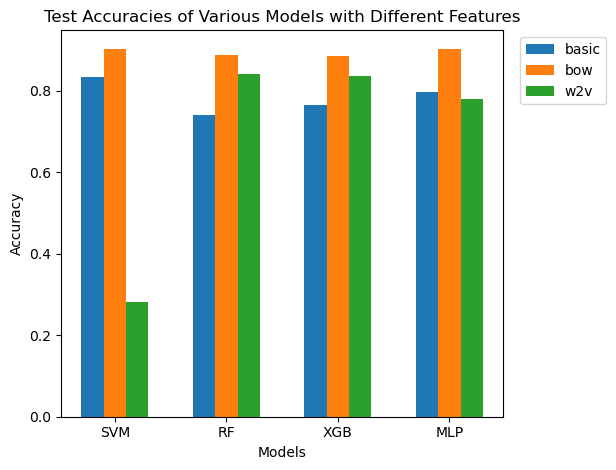

In [125]:
# Plot Results
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_accuracy = [
    [0.8333333333333334, 0.9037037037037037, 0.2814814814814815],  # Accuracies for SVC
    [0.7407407407407407, 0.8888888888888888, 0.8407407407407408],  # Accuracies for RF
    [0.7666666666666667, 0.8851851851851852, 0.837037037037037],   # Accuracies for XGB
    [0.7962962962962963, 0.9037037037037037, 0.7814814814814814]   # Accuracies for MLP
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_accuracies.png')

plt.show()

In [148]:
# Most important features given by RF
rf_bow_feature_importance = bow_rf_clf.best_estimator_.feature_importances_
sorted_feature_importance = np.argsort(-np.abs(rf_bow_feature_importance))
bow_full_feature_names = np.concatenate((vectorizer.get_feature_names_out(), ['query_complexity', 'table_size']))
k = 20
print(f'Top {k} most important features')
print(bow_full_feature_names[sorted_feature_importance[:k]])

Top 20 most important features
['table_size' 'and' 'as' 'moviealias0' 'moviealias0title'
 'actoralias0name' 'moviealias0mid' 'actor' 'course_offeringalias0'
 'actoralias0' 'coursealias0' 'course' 'airport_servicealias1city_code'
 'program_course' 'course_offeringalias0course_id' 'semesteralias0'
 'course_offering' 'movie' 'moviealias0release_year' 'city']


In [ ]:
# Test on Yelp Dataset

In [103]:
yelp = pd.read_csv(os.path.join(data_dir, 'query-runtime-yelp.csv'))
yelp.head()

,query,runtime (ms),db,engine
0,SELECT BUSINESSalias0.NAME FROM BUSINESS AS BU...,55.692196,yelp,mysql
1,SELECT BUSINESSalias0.NAME FROM BUSINESS AS BU...,34.402132,yelp,mysql
2,SELECT USERalias0.USER_ID FROM USER AS USERali...,101.726055,yelp,mysql
3,SELECT BUSINESSalias0.STATE FROM BUSINESS AS B...,12.228251,yelp,mysql
4,SELECT BUSINESSalias0.CITY FROM BUSINESS AS BU...,45.446873,yelp,mysql


In [104]:
yelp['query'] = yelp['query'].str.lower()
complex_keywords = ["join", "distinct", "group by", "count", "order by"]

def check_query_complexity(query):
    words = query.split()
    return int(any(keyword in words for keyword in complex_keywords))

yelp["query_complexity"] = yelp["query"].apply(check_query_complexity)

threshold = 2.7047347051217843
yelp['runtime_boolean'] = (yelp['runtime (ms)'] >= threshold).astype(int)
counts = yelp['runtime_boolean'].value_counts()
print(counts)

runtime_boolean
1    120
Name: count, dtype: int64


In [114]:
with open("../data/table_sizes.json", 'r') as json_file:
    table_names = json.load(json_file)

In [107]:
def compute_table_size(row, table_names):
    query = row['query']
    db = row['db']
    words = query.split()
    count = 0
    for word in words:
        if word in table_names[db]:
            count += table_names[db][word]
    return count

yelp['table_size'] = yelp.apply(lambda row: compute_table_size(row, table_names), axis=1)

In [109]:
del yelp['engine']
del yelp['db']

In [112]:
yelp_x_basic = yelp[['query_complexity', 'table_size']].copy()

yelp_bow_features = vectorizer.transform(yelp['query'].copy())
yelp_additional_features = yelp[['query_complexity', 'table_size']].values
yelp_x_bow = hstack([yelp_bow_features, yelp_additional_features])
print(yelp_x_bow.shape)

(120, 1439)


In [113]:
yelp_labels = yelp['runtime_boolean']

In [135]:
# Nomalize using the original scaler
yelp_norm_basic_X = basic_trainval_scaler.transform(yelp_x_basic)
yelp_norm_bow_X = bow_trainval_scaler.transform(yelp_x_bow.toarray())

In [136]:
_, yelp_basic_res = evaluate(yelp_norm_basic_X, yelp_labels, basic_rf_clf.best_estimator_)
print('Yelp RF Basic')
print(yelp_basic_res['accuracy'])

_, yelp_bow_res = evaluate(yelp_norm_bow_X, yelp_labels, bow_rf_clf.best_estimator_)
print('Yelp RF BOW')
print(yelp_bow_res['accuracy'])

Yelp RF Basic
0.975
Yelp RF BOW
0.0


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packa

In [24]:
# SVC
basic_svc = SVC(C=1000, degree=2, kernel='linear', max_iter=5000)
basic_svc = basic_svc.fit(norm_basic_X_trainval, basic_y_trainval)

bow_svc = SVC(C=10, degree=2)
bow_svc = bow_svc.fit(norm_bow_X_trainval, bow_y_trainval)

w2v_svc = SVC(C=1000, degree=2, kernel='poly')
w2v_svc = w2v_svc.fit(norm_w2v_X_trainval, w2v_y_trainval)

_, basic_svc_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_svc)
print('SVC Basic')
print('f1 score:', basic_svc_res_1['macro avg']['f1-score'])
print('accuracy:', basic_svc_res_1['accuracy'])

_, bow_svc_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_svc)
print('SVC BOW')
print('f1 score:', bow_svc_res_1['macro avg']['f1-score'])
print('accuracy:', bow_svc_res_1['accuracy'])

_, w2v_svc_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_svc)
print('SVC W2V')
print('f1 score:', w2v_svc_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_svc_res_1['accuracy'])

# RF
basic_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50)
basic_rf = basic_rf.fit(norm_basic_X_trainval, basic_y_trainval)

bow_rf = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
bow_rf = bow_rf.fit(norm_bow_X_trainval, bow_y_trainval)

w2v_rf = RandomForestClassifier(criterion='entropy', max_depth=20)
w2v_rf = w2v_rf.fit(norm_w2v_X_trainval, w2v_y_trainval)

_, basic_rf_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_rf)
print('RF Basic')
print('f1 score:', basic_rf_res_1['macro avg']['f1-score'])
print('accuracy:', basic_rf_res_1['accuracy'])

_, bow_rf_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_rf)
print('RF BOW')
print('f1 score:', bow_rf_res_1['macro avg']['f1-score'])
print('accuracy:', bow_rf_res_1['accuracy'])

_, w2v_rf_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_rf)
print('RF W2V')
print('f1 score:', w2v_rf_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_rf_res_1['accuracy'])

# XGBoost
_, basic_xgb_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_xgb_clf.best_estimator_)
print('XGB Basic')
print('f1 score:', basic_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', basic_xgb_res_1['accuracy'])

_, bow_xgb_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_xgb_clf.best_estimator_)
print('XGB BOW')
print('f1 score:', bow_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', bow_xgb_res_1['accuracy'])

_, w2v_xgb_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_xgb_clf.best_estimator_)
print('XGB W2V')
print('f1 score:', w2v_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_xgb_res_1['accuracy'])

# MLP
basic_mlp = MLPClassifier(batch_size=64, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, random_state=291)
basic_mlp = basic_mlp.fit(norm_basic_X_trainval, basic_y_trainval)

bow_mlp = MLPClassifier(batch_size=64, hidden_layer_sizes=(100, 50, 25), random_state=291, solver='sgd')
bow_mlp = bow_mlp.fit(norm_bow_X_trainval, bow_y_trainval)

w2v_mlp = MLPClassifier(activation='tanh', batch_size=64, hidden_layer_sizes=(100, 50, 25), learning_rate='adaptive', learning_rate_init=0.1, max_iter=600, random_state=291, solver='sgd')
w2v_mlp = w2v_mlp.fit(norm_w2v_X_trainval, w2v_y_trainval)

_, basic_mlp_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_mlp)
print('MLP Basic')
print('f1 score:', basic_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', basic_mlp_res_1['accuracy'])

_, bow_mlp_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_mlp)
print('MLP BOW')
print('f1 score:', bow_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', bow_mlp_res_1['accuracy'])

_, w2v_mlp_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_mlp)
print('MLP W2V')
print('f1 score:', w2v_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_mlp_res_1['accuracy'])

SVC Basic
f1 score: 0.791448531557356
accuracy: 0.8333333333333334
SVC BOW
f1 score: 0.88
accuracy: 0.9037037037037037
SVC W2V
f1 score: 0.22970588235294115
accuracy: 0.2814814814814815
RF Basic
f1 score: 0.678451447768357
accuracy: 0.7518518518518519
RF BOW
f1 score: 0.8511138886846555
accuracy: 0.8888888888888888
RF W2V
f1 score: 0.7744360902255638
accuracy: 0.825925925925926
XGB Basic
f1 score: 0.7352570388009525
accuracy: 0.7666666666666667
XGB BOW
f1 score: 0.860803911459979
accuracy: 0.8851851851851852
XGB W2V
f1 score: 0.7530391977515757
accuracy: 0.7962962962962963


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Basic
f1 score: 0.7631541172905469
accuracy: 0.7962962962962963
MLP BOW
f1 score: 0.877963980251721
accuracy: 0.9037037037037037
MLP W2V
f1 score: 0.733054042731462
accuracy: 0.7814814814814814


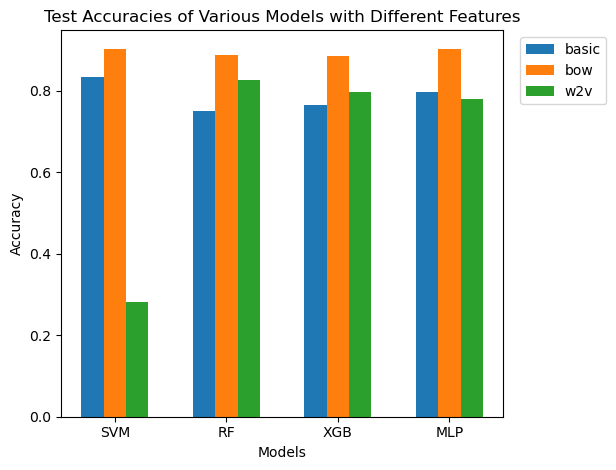

In [25]:
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_accuracy = [
    [0.8333333333333334, 0.9037037037037037, 0.2814814814814815], # SVC
    [0.7518518518518519, 0.8888888888888888, 0.825925925925926], # RF
    [0.7666666666666667, 0.8851851851851852, 0.7962962962962963], # XGB
    [0.7962962962962963, 0.9037037037037037, 0.7814814814814814] # MLP
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_accuracies.png')

plt.show()

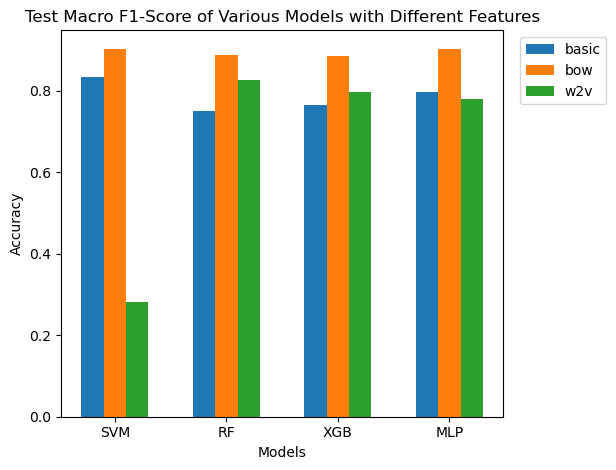

In [28]:
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_f1 = [
    [0.791448531557356, 0.88, 0.22970588235294115],
    [0.678451447768357, 0.8511138886846555, 0.7744360902255638],
    [0.7352570388009525, 0.860803911459979, 0.7530391977515757],
    [0.7631541172905469, 0.877963980251721, 0.733054042731462]
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Macro F1-Score of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_f1.png')

plt.show()